In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams["savefig.dpi"] = 96
rcParams["figure.dpi"] = 96

# The polynomial decomposition approach

## Introduction

The polynomial decomposition approach was originally proposed by [Keery et al. (2012)](
https://doi.org/10.1190/geo2011-0244.1). It consists of performing Debye decomposition of the SIP spectra with the assumption that the relaxation time distribution (RTD) of that spectra can be approximated by a polynomial function. In this approach, the complex resistivity $\rho^*$ is given by 

\begin{equation}
\rho^* = \rho_0 \left[ 1 - \sum_{l=1}^{L} m_l\left(1-\frac{1}{1+(i\omega\tau_l)} \right) \right],
\end{equation}

where $\omega$ is the measurement angular frequencies
($\omega=2\pi f$) and $i$ is the imaginary unit. BISIP uses a generalized Cole-Cole polynomial decomposition scheme by including a user-defined Cole-Cole exponent ($c$). If $c = 1$, the equation is equivalent to Debye decomposition. If $c=0.5$, the equation is known as Warburg decomposition. For any other values we refer to this scheme as the generalized Cole-Cole decomposition. The complex resistivity is thus given by

\begin{equation}
\rho^* = \rho_0 \left[ 1 - \sum_{l=1}^{L} m_l\left(1-\frac{1}{1+(i\omega\tau_l)^c} \right) \right],
\end{equation}

where $L$ is an arbitrary real number that defines the discretization level of the RTD. In practice BISIP uses $L = 2\times n_{freq}$, where $n_{freq}$ is the number of measurement points in the frequency range. The RTD is defined by the distribution of $m_l$ values as a function of $\tau_l$ values. According to [Keery et al. (2012)](https://doi.org/10.1190/geo2011-0244.1), the RTD can be written as

\begin{equation}
m_l = \sum_{p=0}^P a_p (\log_{10} \tau_l)^p,
\end{equation}

where $a_p$ are polynomial coefficients and $P$ is the polynomial degree of the approximation. In practice, $P$ is often set to 3, 4 or 5. The user should aim to use the lowest degree possible while maintaining a satisfying fit with the data. As a result, $\rho^*$ depends on $P+1$ parameters:

- $\rho_0 \in [0, \infty)$, the direct current resistivity $\rho_0 = \rho^*(\omega\to 0)$.
- $a_p$, the $P$ polynomial coefficients.

From the recovered $a_p$ and $\rho_0$ values, the user can then compute the RTD and extract several integrating parameters, such as total chargeability and mean relaxation time. The user is referred to [Keery et al. (2012)](https://doi.org/10.1190/geo2011-0244.1) for the definition of these parameters.

## Exploring the parameter space

First import the required packages.

In [2]:
import numpy as np
from bisip import PolynomialDecomposition
from bisip import DataFiles

np.random.seed(42)

In [3]:
# This will get one of the example data files in the BISIP package
data_files = DataFiles()
filepath = data_files['SIP-K389176']

# Define MCMC parameters and Dias model
nwalkers = 32
nsteps = 1000
model = PolynomialDecomposition(filepath=filepath, nwalkers=nwalkers, nsteps=nsteps)
# Fit model to data
model.fit()

100%|██████████| 1000/1000 [00:01<00:00, 513.04it/s]


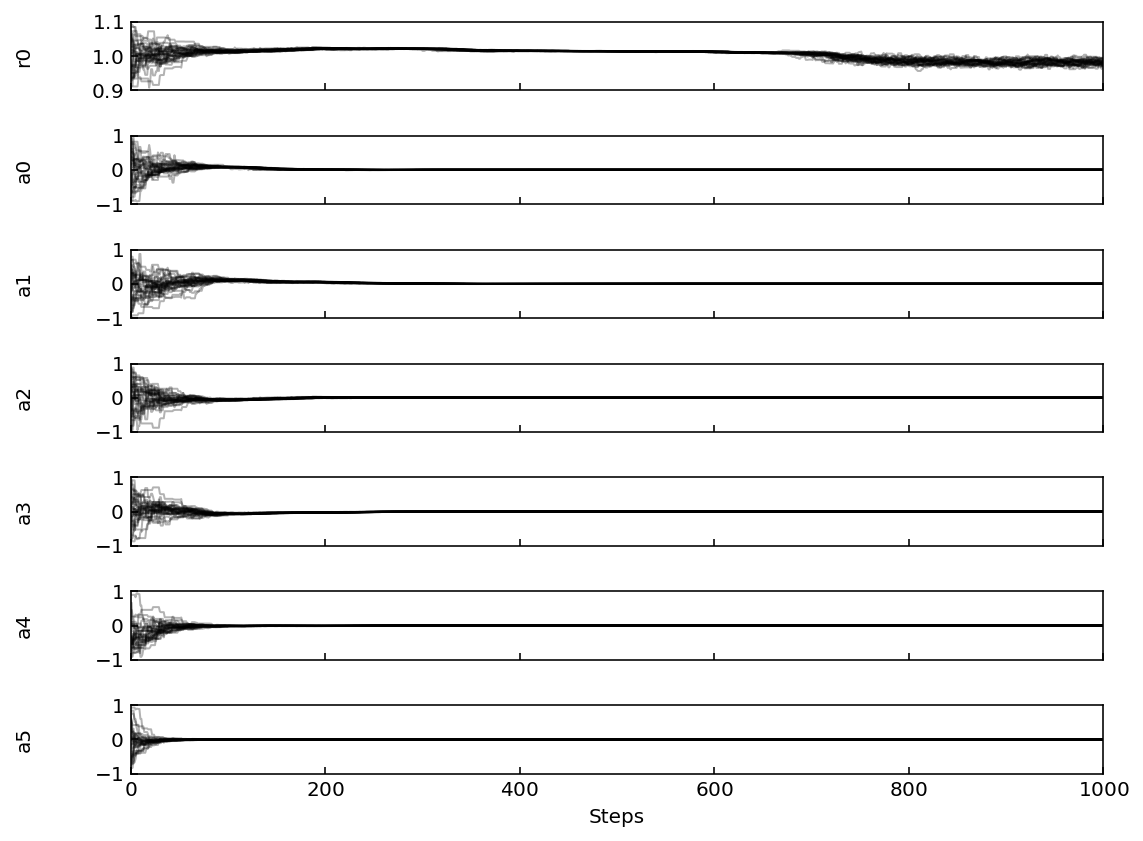

In [4]:
fig = model.plot_traces()

The walkers have reached a unique stationary state. Let's inspect the fit quality by discarding the burn-in period.

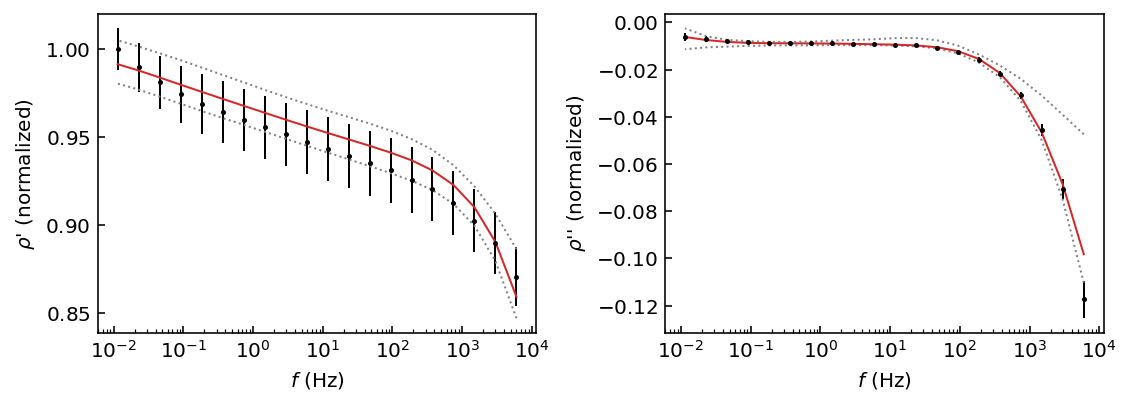

In [5]:
# Plot the fit by discarding the first 500 steps
fig = model.plot_fit(discard=500)